In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
os.chdir("../")
sys.path.append("./")

In [56]:
from glob import glob
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from common.evaluation import evaluator
from dtaidistance import dtw
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [23]:
def load_ouput(result_dir, model):
    score = np.load(os.path.join(result_dir, "{}_score.npz".format(model)))["arr_0"]
    label = np.load(os.path.join(result_dir, "{}_label.npz".format(model)))["arr_0"]
    
    score = normalize(score.reshape(1, -1)).reshape(-1)
    return score, label

def sigmoid(x):
    x = 1/(x+1)
    return 1. / (1 + np.exp(-x))


In [24]:
dataset = "SMD"
subdataset = "machine-1-1"
result_dir = f"./demo/output/{dataset}/{subdataset}"

In [25]:
data_dict = defaultdict(dict)
data_dict["lstm"]["score"], data_dict["lstm"]["label"] = load_ouput(result_dir, "lstm")
data_dict["lstm_vae"]["score"], data_dict["lstm_vae"]["label"] = load_ouput(result_dir, "lstm_vae")
data_dict["dagmm"]["score"], data_dict["dagmm"]["label"] = load_ouput(result_dir, "dagmm")
data_dict["dagmm"]["score"], data_dict["dagmm"]["label"] = data_dict["dagmm"]["score"][32: ], data_dict["dagmm"]["label"][32: ]

In [26]:
data_dict["dagmm"]["score"].shape, data_dict["lstm_vae"]["score"].shape

((28447,), (28447,))

In [27]:
eva = evaluator(
    ["auc", "f1", "pc", "rc"],
    data_dict["lstm"]["score"],
    data_dict["lstm"]["label"],
    iterate_threshold=True,
    iterate_metric="f1",
    point_adjustment=True,
)
eval_results = eva.compute_metrics()

Iterating threshold.


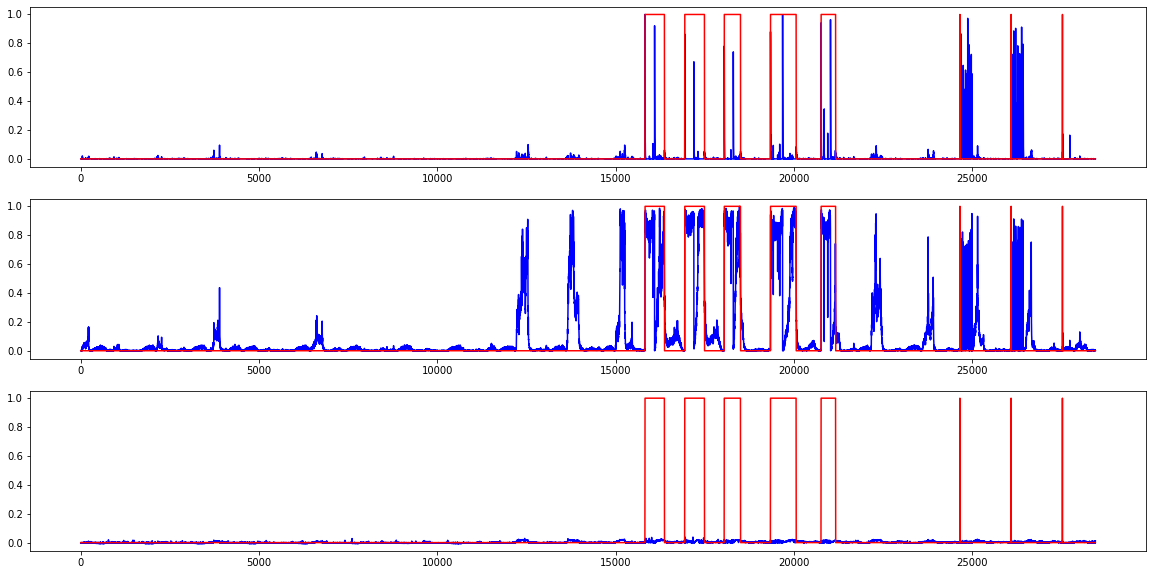

In [106]:
est = MinMaxScaler(clip=True)
data_dict["lstm"]["score"] = est.fit_transform(data_dict["lstm"]["score"].reshape(-1,1))
data_dict["lstm_vae"]["score"] = est.fit_transform(data_dict["lstm_vae"]["score"].reshape(-1,1))

fig, ax = plt.subplots(nrows=3, sharey=True, figsize=(20,10))


ax[0].plot(data_dict["lstm"]["score"], 'b', label="lstm-score", alpha=1)
ax[0].plot(data_dict["lstm"]["label"], 'r', label='label', alpha=1)

ax[1].plot(data_dict["lstm_vae"]["score"], 'b', label="lstm-score", alpha=1)
ax[1].plot(data_dict["lstm_vae"]["label"], 'r', label='label', alpha=1)

ax[2].plot(data_dict["dagmm"]["score"], 'b', label="dagmm-score", alpha=1)
ax[2].plot(data_dict["dagmm"]["label"], 'r', label='label', alpha=1)

In [ ]:
def compute_salience(score, label):
    for line in range(0, 1, 100):

In [113]:
def l2_norm(arr):
    return normalize(arr.reshape(1,-1)).reshape(-1)
    
    
def onehot2interval(arr):
    result = []
    record = False
    for idx, item in enumerate(arr):
        if item == 1 and not record:
            start = idx
            record = True
        if item == 0 and record:
            end = idx # not include the end point, like [a,b)
            record = False
            result.append((start, end))
    return result

def compute_diff(intervals, total_length):
    '''
    output: intervals left within total_length, like [a,b)
    '''
    
    left_intervals = []
    for idx, (start, end) in enumerate(intervals):
        if idx == 0:
            if start != 0:
                left_intervals.append((0, start))
        elif idx == (len(intervals) - 1):
            left_intervals.append((end, total_length))
        else:
            _, last_end = intervals[idx-1]
            left_intervals.append((last_end, start))
            
    return left_intervals

def get_windows(ts, window_size=128, stride=1):
    i = 0
    ts_len = ts.shape[0]
    windows = []
    while i + window_size < ts_len:
        windows.append(ts[i : i + window_size])
        i += stride
    return np.array(windows, dtype=np.float32)


def nonabs_cityblock(ts1, ts2):
    return min(ts1 - ts2)

def compute_interval_distance(normal_ts, anomaly_ts, stride=1):
#     return wasserstein_distance(normal_ts, anomaly_ts)
    window_size = len(anomaly_ts)
    normal_windows = get_windows(normal_ts, window_size, stride)
#     print("anomalous:")
#     print(anomaly_ts)
#     print("normal")
#     print(normal_windows)
#     print(anomaly_ts, normal_windows[0])
    distances = np.array([nonabs_cityblock(anomaly_ts, row) for row in normal_windows])
#     distances = pairwise_distances(anomaly_ts.reshape(1,-1), normal_windows, metric='cityblock') / normal_windows.shape[1]
#     distances = euclidean_distances(anomaly_ts.reshape(1,-1), normal_windows)
#     print(distances)
#     distances = l2_norm(distances)
#     print(distances)
#     plt.figure()
#     plt.plot(sorted(distances.reshape(-1)))
    return distances.min()


def compute_salience(score, label):
    score = score.reshape(-1)
    label = label.reshape(-1)
    anomaly_intervals = onehot2interval(label)
    normal_intervals = compute_diff(anomaly_intervals, len(label))
    print(score.shape)
    
    total_salience = {}
    for anomaly_start, anomaly_end in anomaly_intervals:
        print(anomaly_start, anomaly_end)
        salience = 0
        valid_count = 0
        for normal_start, normal_end in normal_intervals:
            score_a = score[anomaly_start: anomaly_end]
            score_n = score[normal_start: normal_end]
            if len(score_n) > len(score_a): # only consider long normal ranges
                salience += compute_interval_distance(score_n, score_a)
                valid_count += 1
        total_salience[(anomaly_start, anomaly_end)] = salience/valid_count
    print("total_salience", total_salience)
    print("avg_salience", np.mean([v for k,v in total_salience.items()]))


In [ ]:
best_f1, best_theta, best_adjust_pred, best_raw_pred = iter_thresholds(
    anomaly_score, anomaly_label, metric="f1", adjustment=True
)

try:
    auc = roc_auc_score(anomaly_label, anomaly_score)
except ValueError as e:
    auc = 0
    print("All zero in anomaly label, set auc=0")

adj_f1 = f1_score(anomaly_label, best_adjust_pred)
adj_precision = precision_score(anomaly_label, best_adjust_pred)
adj_recall = recall_score(anomaly_label, best_adjust_pred)

In [116]:
score = data_dict["lstm"]["score"]
label = data_dict["lstm"]["label"]
compute_salience(score, label)

score = data_dict["lstm_vae"]["score"]
label = data_dict["lstm_vae"]["label"]
compute_salience(score, label)


score = np.zeros(data_dict["dagmm"]["score"].shape[0])
compute_salience(score, label)



# score = data_dict["dagmm"]["score"]
# label = data_dict["dagmm"]["label"]
# compute_salience(score, label)


(28447,)
15818 16364
16932 17486
18040 18497
19336 20057
20755 21164
24648 24651
26083 26085
27523 27525
total_salience {(15818, 16364): -0.17626610398292542, (16932, 17486): -0.21862380845206125, (18040, 18497): -0.19588109850883484, (19336, 20057): -0.27768831253051757, (20755, 21164): -0.1910315752029419, (24648, 24651): -0.19620418548583984, (26083, 26085): -0.1972607970237732, (27523, 27525): -0.18780505657196045}
avg_salience -0.2050951172198568
(28447,)
15818 16364
16932 17486
18040 18497
19336 20057
20755 21164
24648 24651
26083 26085
27523 27525
total_salience {(15818, 16364): -0.4390069879591465, (16932, 17486): -0.5980841155563082, (18040, 18497): -0.5665342584252357, (19336, 20057): -0.6846258014440536, (20755, 21164): -0.5670970417559147, (24648, 24651): -0.5656055454164743, (26083, 26085): -0.5613623075187206, (27523, 27525): -0.5653911456465721}
avg_salience -0.5684634004653032
(28447,)
15818 16364
16932 17486
18040 18497
19336 20057
20755 21164
24648 24651
26083 26085
2

In [89]:
# arr = [0,1,0,1,0,0,0,1,1,0,0,0]
arr = label
intervals = onehot2interval(arr) 
print(intervals)
left_intervals = compute_diff(intervals, len(arr))
print(left_intervals)

[(15818, 16364), (16932, 17486), (18040, 18497), (19336, 20057), (20755, 21164), (24648, 24651), (26083, 26085), (27523, 27525)]
[(0, 15818), (16364, 16932), (17486, 18040), (18497, 19336), (20057, 20755), (21164, 24648), (24651, 26083), (27525, 28447)]


In [1]:
import pyspot as ps # name of the python3 package
import pandas as pd
import matplotlib.pyplot as plt

# loading data
MAWI_17 = pd.read_csv("mawi_170812_50_50.csv", index_col=[0])
MAWI_18 = pd.read_csv("mawi_180812_50_50.csv", index_col=[0])

# we keep only the ratio of SYN packets
rSYN_17 = MAWI_17['rSYN']
rSYN_18 = MAWI_18['rSYN']

# initialization of the Spot object
q = 5e-4
n_init = 2000
spot = ps.Spot(q, n_init, up=True, down=False)


## CALIBRATION
for r in rSYN_17[-n_init:]:
	spot.step(r)


## ANOMALY DETECTION

# we init some structure to log what flags the algorithm
up_threshold = [0.0] * len(rSYN_18)
anomalies_x = []
anomalies_y = []
i = 0
for r in rSYN_18:
	event = spot.step(r)
	
	if event == 1: # anomaly case
		anomalies_x.append(i)
		anomalies_y.append(r)
		
	up_threshold[i] = spot.get_upper_threshold()
	i = i+1

# Plotting stuff 
plt.plot(rSYN_18, lw=2, color="#1B4B5A")
f1, = plt.plot(up_threshold, ls='dashed', color="#AE81FF", lw=2)
f2 = plt.scatter(anomalies_x, anomalies_y, color="#F55449")
plt.legend([f1, f2], ['Threshold', 'Anomalies'])


plt.xticks(range(0,18001,3000), range(0,901,150)) # we change the ticks to make it corresponds to the true time : 1 it = 50 ms
plt.xlabel('Time (s)')
plt.ylabel('Ratio of SYN packets')

ModuleNotFoundError: No module named 'pyspot'